In [20]:
import logging
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (LabelEncoder,
                                   PowerTransformer)
from sklearn.metrics import (accuracy_score, 
f1_score, 
ConfusionMatrixDisplay,
RocCurveDisplay,
DetCurveDisplay,
classification_report)
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
# Cargar datos
# Hill, LaPan, Li and Haney (2007). Impact of image segmentation on high-content screening data quality for SK-BR-3 cells, BMC Bioinformatics, Vol. 8, pg. 340
df_raw = pd.read_csv("skbr_cells.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [3]:
# Predecir si la célula está pobremente segmentada o bien segmentada
# ps y ws
df_raw.sample(10, random_state=2024)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,DiffIntenDensityCh1,DiffIntenDensityCh3,DiffIntenDensityCh4,EntropyIntenCh1,EntropyIntenCh3,EntropyIntenCh4,EqCircDiamCh1,EqEllipseLWRCh1,EqEllipseOblateVolCh1,EqEllipseProlateVolCh1,EqSphereAreaCh1,EqSphereVolCh1,FiberAlign2Ch3,FiberAlign2Ch4,FiberLengthCh1,FiberWidthCh1,IntenCoocASMCh3,IntenCoocASMCh4,IntenCoocContrastCh3,IntenCoocContrastCh4,IntenCoocEntropyCh3,IntenCoocEntropyCh4,IntenCoocMaxCh3,IntenCoocMaxCh4,KurtIntenCh1,KurtIntenCh3,KurtIntenCh4,LengthCh1,NeighborAvgDistCh1,NeighborMinDistCh1,NeighborVarDistCh1,PerimCh1,ShapeBFRCh1,ShapeLWRCh1,ShapeP2ACh1,SkewIntenCh1,SkewIntenCh3,SkewIntenCh4,SpotFiberCountCh3,SpotFiberCountCh4,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1781,208412526,Train,PS,104.208986,372,52.304225,114.822535,38.219718,58.383099,1.197572,0.916018,47.723077,32.449231,44.200000,6.618542,5.754717,6.130370,21.766490,3.149571,970.934236,308.275027,1488.424036,5399.627809,1.798240,1.628918,42.470578,9.150215,0.034282,0.027425,9.727554,9.684369,6.596711,6.767355,0.179641,0.148734,-0.748070,0.501340,-0.466078,40.981491,272.108155,40.965177,108.108585,103.241588,0.569050,2.568379,2.182616,0.322584,1.014746,0.563009,3,8,18568,40408,13568,20726,33.307494,37.597455,49.828379,15.956169,81,277
856,208340336,Train,PS,47.697886,155,77.885135,74.864865,181.189189,180.020270,1.210777,0.915863,69.298851,167.337165,117.505747,6.482772,6.531989,5.498849,14.054166,1.745990,194.596516,111.453365,620.526077,1453.496094,1.670428,1.697290,22.163400,7.460558,0.011197,0.049914,13.263566,7.597252,6.822938,5.935919,0.046512,0.227273,2.311459,2.274367,-0.858890,19.627014,156.396339,23.547619,72.777683,59.247916,0.594770,1.476922,1.689375,1.440096,1.576746,0.395741,1,2,11527,10933,26816,26643,61.789587,180.934039,156.294311,13.289130,316,136
1281,208322195,Test,PS,79.971064,393,46.592000,169.530667,88.418667,69.330667,1.364899,0.831408,45.782353,72.547059,47.517647,6.540164,6.904843,5.866131,22.371230,2.431030,926.112186,380.954673,1572.278912,5862.302132,1.345211,1.365141,49.185219,8.439154,0.009525,0.056886,12.765063,5.396383,7.332716,6.026215,0.061584,0.235988,1.911160,2.002762,-0.243539,37.960175,251.299826,27.547897,119.603694,115.248746,0.516369,1.892986,2.546399,1.432852,1.314970,0.799602,2,7,17472,63200,33157,25999,39.645179,79.688849,68.986743,20.053071,423,228
1878,208332514,Test,PS,57.764663,202,38.015544,4.823834,83.751295,8.056995,1.339736,0.920427,43.698507,65.644776,12.492537,6.150100,6.661873,1.756289,16.049181,4.029720,440.245535,109.249654,809.199546,2164.498351,1.831463,1.787996,36.769863,5.936512,0.006776,0.587631,20.178931,0.726726,7.470850,1.745968,0.029070,0.779070,-0.698097,-0.863143,7.119124,34.717688,224.396938,21.524363,103.559758,85.412750,0.486581,2.899086,2.659559,0.477875,0.265366,2.726905,2,5,7337,739,16164,1555,25.612796,53.556327,19.686977,11.975392,328,55
1013,208405198,Test,PS,61.292430,380,104.787879,247.005510,50.143251,56.165289,1.236340,0.859420,72.771772,46.447447,44.333333,7.272604,4.259892,4.647794,22.010380,2.169000,833.127175,384.106517,1521.965986,5583.174906,1.616603,1.750655,40.458732,9.838386,0.212570,0.200683,2.640614,2.938788,4.253711,4.379128,0.456193,0.447130,0.090800,2.249119,0.174302,32.754695,253.375607,22.616692,125.503419,100.594235,0.646035,1.821623,2.023008,0.586913,1.608539,1.097701,3,12,38038,89301,18202,20388,59.918187,73.120312,72.884340,17.981055,62,172
128,208384284,Test,PS,16.587410,212,22.103448,2.113300,44.640394,83.610837,1.232394,0.927574,37.756164,29.657534,52.408219,5.484337,6.114417,6.585955,16.459712,2.508185,374.666975,149.377711,851.126984,2334.884234,1.378331,1.480147,28.007204,7.971649,0.007786,0.008483,16.147870,11.873596,7.229538,7.182142,0.032086,0.037433,0.030950,-0.223412,0.033176,26.179370,248.576677,19.235635,115.003743,71.957706,0.580217,1.8

In [4]:
# Transformación y preprocesamiento
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1 # slice sirve para cortar el texto a un máximo de 40 caracteres

    )
    .loc[:,['perimch1','eqsphereareach1','entropyintench1','class']] # .loc selecciona filas o columna en particular
    .drop_duplicates()
    .rename(columns={"class": "target"})
    .astype({"target" : "category"}) #Drop duplicate para deshacernos de los duplicados, rename cambiar nombre de la columna objetivo y con astype lo convierto a variable categórica
    
)

In [5]:
# Mover la columna target al frente
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)

In [28]:
# EDA
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['target'])
power_transformer = PowerTransformer()
X_train = power_transformer.fit_transform(df_train.drop('target',axis=1))
X_test = power_transformer.transform(df_test.drop('target',axis=1))
df_train_tf = pd.DataFrame(X_train, columns=df_train.drop('target',axis=1).columns)
df_test_tf = pd.DataFrame(X_test, columns=df_test.drop('target',axis=1).columns)
df_train_x = pd.concat([df_train['target'],df_train_tf])
df_test_x = pd.concat([df_test['target'],df_test_tf])
df_train = df_train_x
df_test = df_test_x
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3230 entries, 1671 to 1614
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   target           1615 non-null   category
 1   perimch1         1615 non-null   float64 
 2   eqsphereareach1  1615 non-null   float64 
 3   entropyintench1  1615 non-null   float64 
dtypes: category(1), float64(3)
memory usage: 104.2 KB


In [29]:
display(df_train.describe(include="number").T)
display(df_train.describe(include="category").T)

,count,mean,std,min,25%,50%,75%,max
perimch1,1615.0,3.112969e-14,1.00031,-2.278852,-0.744494,-0.037161,0.711497,2.474413
eqsphereareach1,1615.0,2.393187e-13,1.00031,-1.765610,-0.813263,-0.008468,0.752210,2.406261
entropyintench1,1615.0,1.622369e-15,1.00031,-2.924521,-0.711637,0.061764,0.668714,3.161730


,count,unique,top,freq
target,1615,2,PS,1040


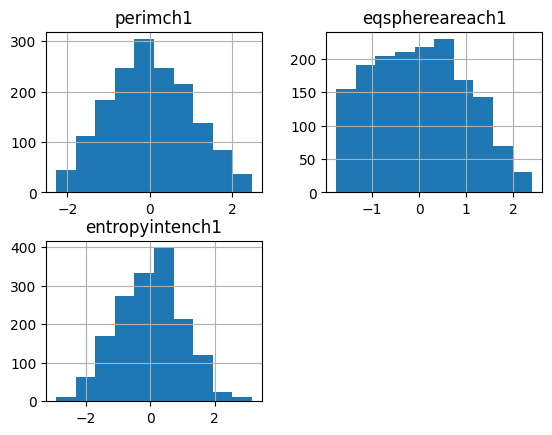

In [30]:
# Análisis univariado
df_train.hist()
plt.show()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 1671     PS
806      WS
1196     PS
316      WS
1457     PS
       ... 
1610    NaN
1611    NaN
1612    NaN
1613    NaN
1614    NaN
Name: target, Length: 3230, dtype: category
Categories (2, object): ['PS', 'WS']

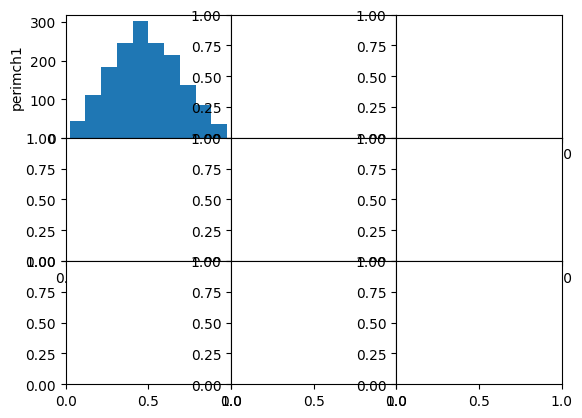

In [34]:
# Análisis bivariado
pd.plotting.scatter_matrix(df_train, c=df_train["target"])
plt.show()

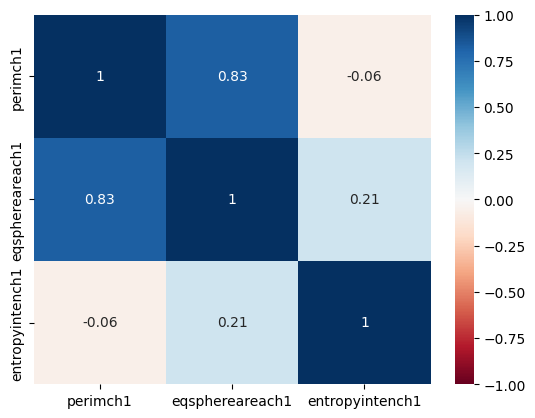

In [35]:
sns.heatmap(df_train.select_dtypes("number").corr(),vmin=-1, vmax=1, annot=True, cmap="RdBu") # Correlación
plt.show()

In [36]:
X_train= df_train.drop("target", axis=1).reset_index(drop=True) # Tengo que separar los valores independientes de la variable dependiente
y_train= df_train["target"].reset_index(drop=True) 
X_test= df_test.drop("target", axis=1).reset_index(drop=True) # Tengo que separar los valores independientes de la variable dependiente
y_test= df_test["target"].reset_index(drop=True) 

In [37]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [38]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train_enc)

RandomForestClassifier()

In [39]:
y_pred = clf_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test_enc, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test_enc, y_pred):.2f}')
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred, display_labels=label_encoder.classes_)
plt.show()

Accuracy: 0.82


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

ValueError: Expected 'estimator' to be a binary classifier. Got 3 classes instead.

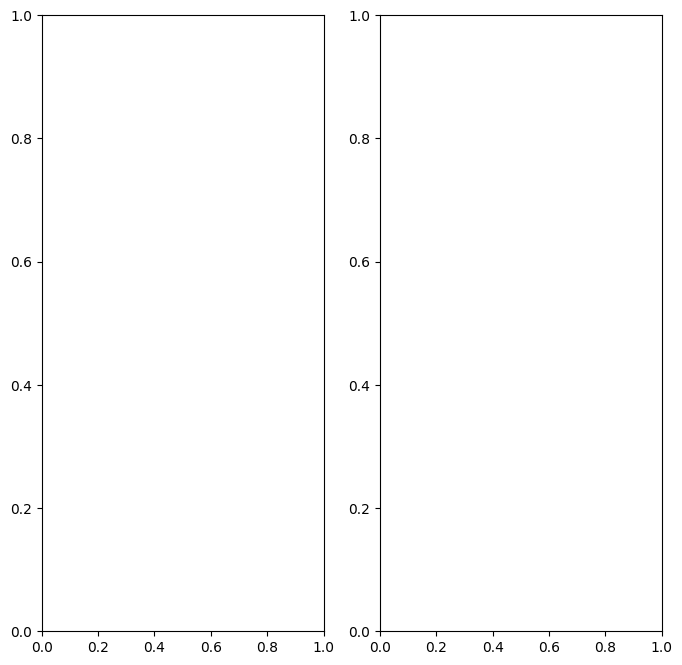

In [40]:
fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(8,8))
RocCurveDisplay.from_estimator(
    clf_rf, X_test, y_test_enc, ax=ax_roc, plot_chance_level=True
)
DetCurveDisplay.from_estimator(
    clf_rf, X_test, y_test_enc, ax=ax_det
)
ax_roc.set_title("Receiver Operating Characteristic (ROC) Curves")
ax_det.set_title("Detection Error Tradeoff (DET) Cruves")
ax_roc.grid(linestyle='--')
ax_det.grid(linestyle='--')
ax_det.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

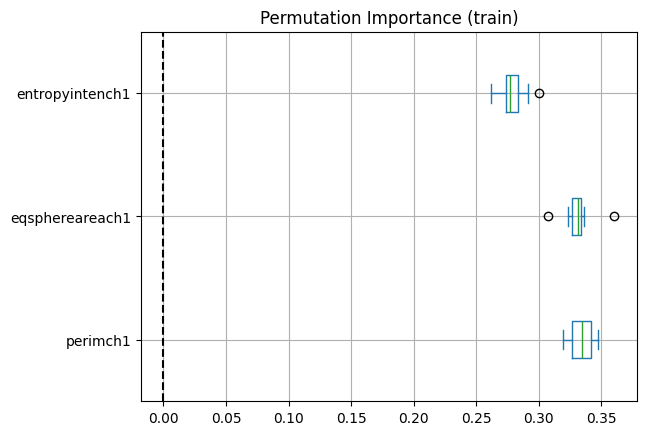

In [16]:
importance = permutation_importance(clf_rf, X_train, y_train_enc, n_repeats=10, random_state=2024)
importance_df = pd.DataFrame(importance.importances.T, columns=X_train.columns)
ax = importance_df.plot.box(vert=False)
ax.axvline(x=0, color="k", linestyle="--")
ax.grid(True)
ax.set_title("Permutation Importance (train)")
plt.show()

In [17]:
model_dict = {
    "model": clf_rf,
    "predictors": X_train.columns.to_list(),
    "algorithm name": "Random Forest Classifier"
}

In [18]:
try: 
    joblib.dump(model_dict, "cell_segmentation_model_rf.joblib")
    logger.info("saving was successful")
except Exception as e:
    logger.error(f"An error has ocurred {e}")